## Introduction

Site-level NMEC projects are subject to a predictability analysis process which helps implementors evaluate the project's fit within the NMEC framework. A predictability analysis is the first attempt at modeling a building's energy consumption and is driven by three key metrics:

- Coefficient of Variation of Root Mean Squared Error (CV(RMSE)): a measure of random error in a model's fit when evaluated against the actual data
- Net Mean Bias Error (NMBE): a measure of total bias error in a model's fit when evaluated against the actual data
- Coefficient of Determine (R2): a measure of the variation in the dependent variable captured by the independent variables 

This post show how focusing solely on these metrics can lead to ill-suited projects' selection into NMEC programs and what you can do to ensure a strong portfolio of projects.

In [1]:
## Load in required packages

import_package = function(package_name){ ## function to suppress messages and warnings during package load
    suppressWarnings(suppressMessages(require(package_name, character.only = TRUE)))
}

import_package("nmecr")
import_package("ggplot2")

## Data Read In and Exploratory Analysis

In [2]:
eload_data <- readRDS("Data/Processed Energy Consumption - multiyear.rds")
temp_data <- readRDS("Data/Processed Temperature - multiyear.rds")

In [3]:
# Align energy and temperature data at daily intervals

energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

A predictability analysis usually begins by charting the energy use against time and temperature to visualize energy use patterns and identify major non-routine events that would make the building clearly ineligible for an NMEC program.

Here we have energy use data from a commercial facility in southern California:

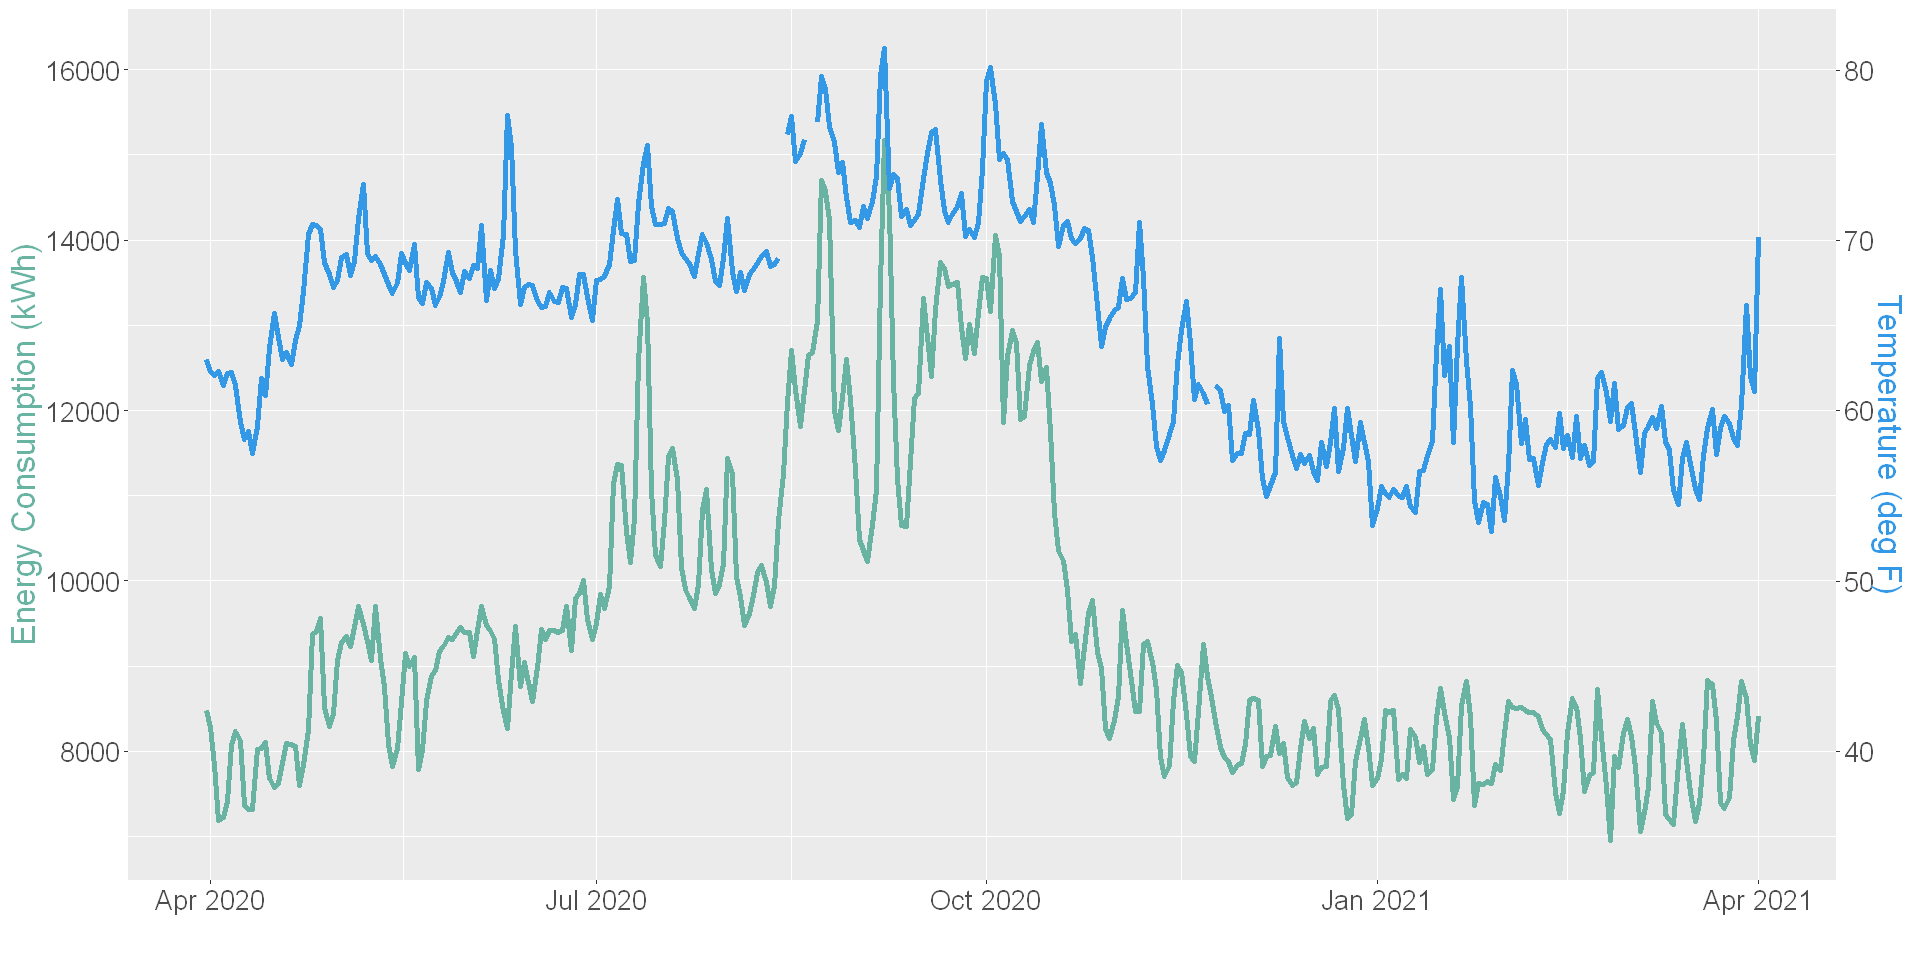

In [4]:
# Plot energy use against time

options(repr.plot.width=16, repr.plot.height=8)

energy_temp_line_df <- tidyr::pivot_longer(energy_temp_df,
                                           cols = c("eload", "temp"))

temperatureColor <- "#69b3a2"
priceColor <- rgb(0.2, 0.6, 0.9, 1)

energy_temp_df %>%
    ggplot2::ggplot(aes(x = time)) +
    geom_line(aes(y=eload), size=1.5, color=temperatureColor) + 
    geom_line( aes(y=temp*200), size=1.5, color=priceColor) +
    scale_y_continuous(
    name = "Energy Consumption (kWh)",    
    sec.axis = sec_axis(~.*1/200, name="Temperature (deg F)")) +
    theme(
    axis.title.y = element_text(color = temperatureColor, size=20),
    axis.title.y.right = element_text(color = priceColor, size=20),
    text = element_text(size = 20)) +
    xlab("") 

The temperature data is plotted in blue on the right-axis, and the energy use data is plotted in green on the left-axis. The two datastreams are plotted as a scatterplot below:

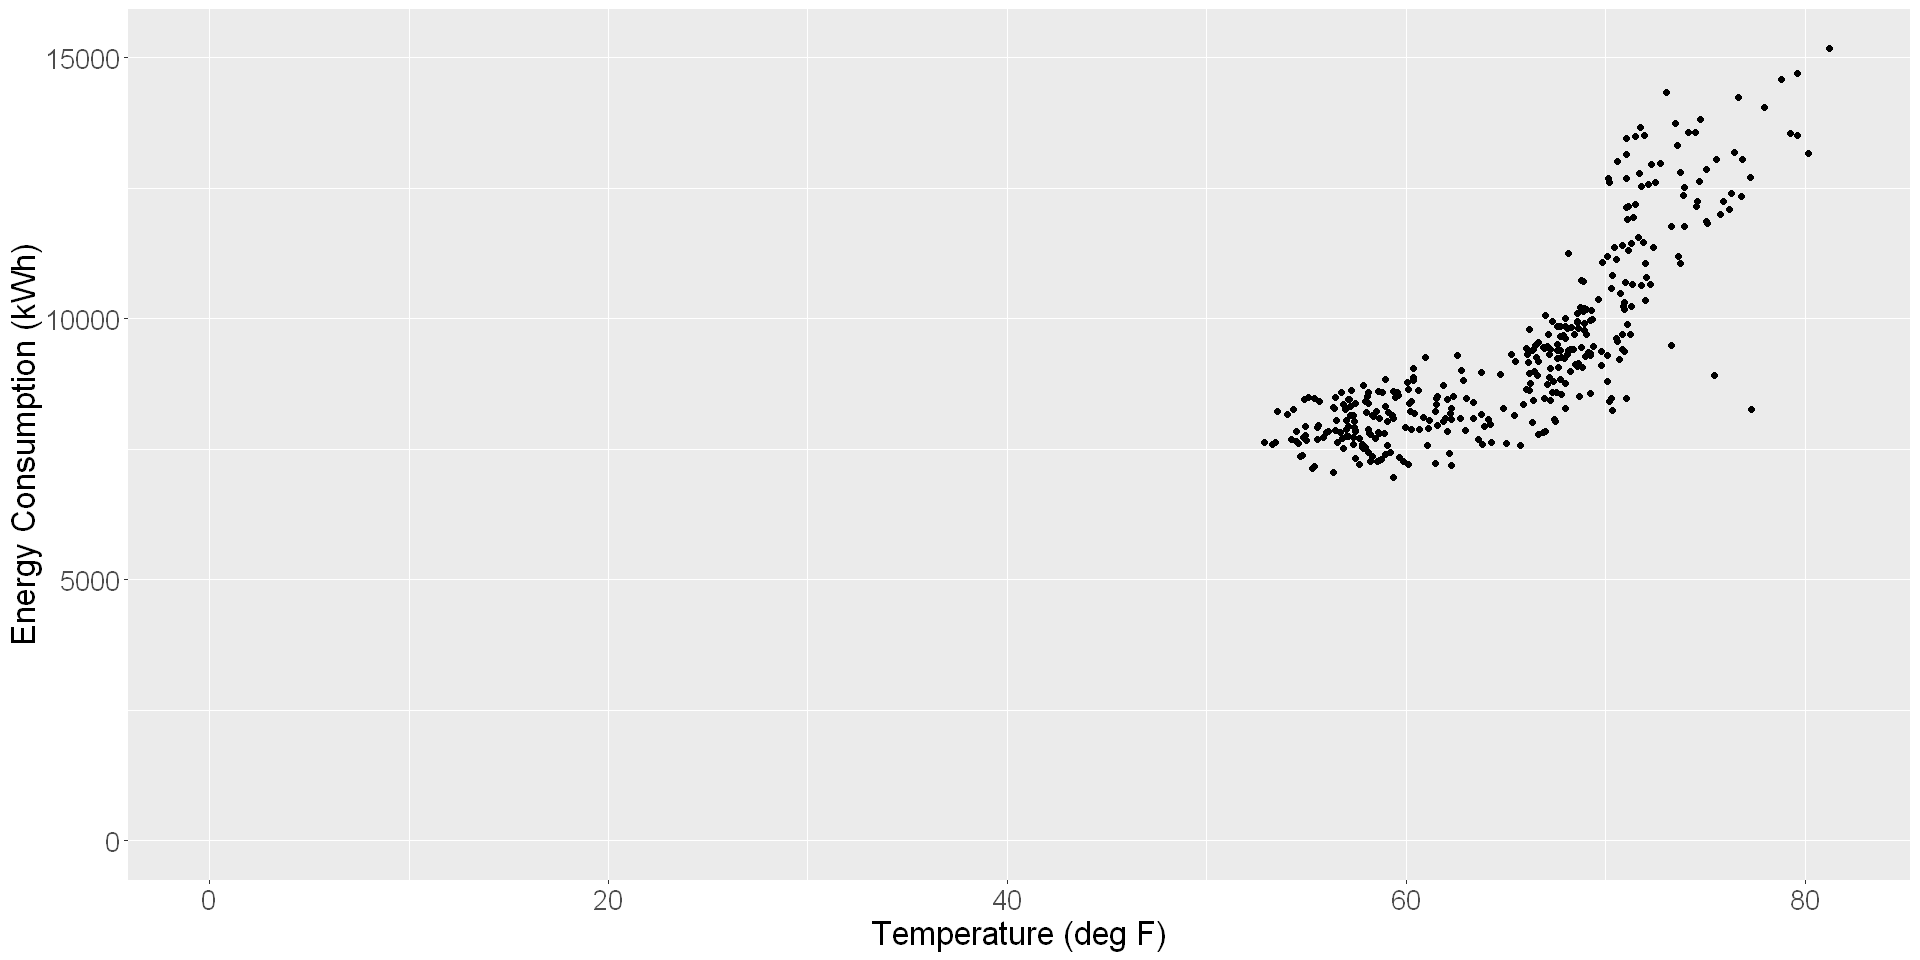

In [5]:
# Plot energy use against temperature

options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

Here is a zoomed-in version of the scatterplot:

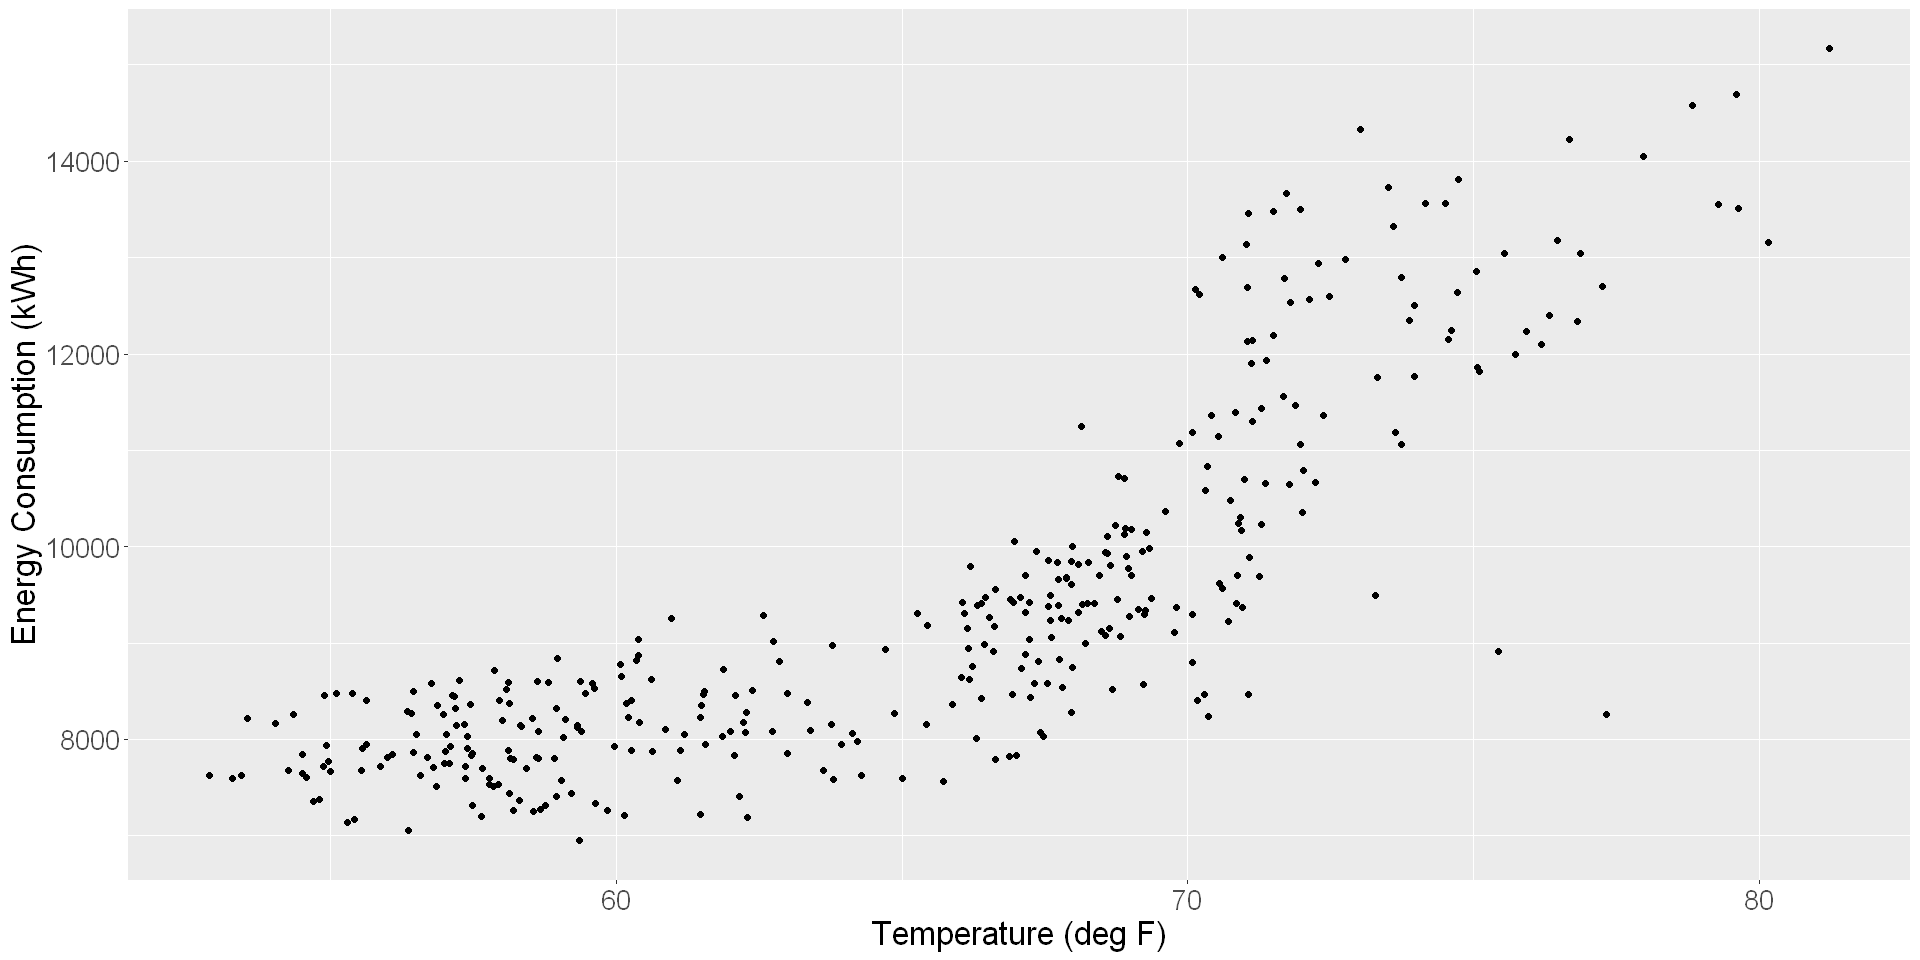

In [6]:
# Plot energy use against temperature - zoomed in

options(repr.plot.width=16, repr.plot.height=8)

energy_temp_df[complete.cases(energy_temp_df), ] %>%
    ggplot2::ggplot(aes(x = temp, y = eload)) +
    geom_point() +
    theme(text = element_text(size = 20)) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")

Given the shape of the scatter plot, a three parameter cooling model seems appropriate. However, as seen in the time-series chart, the energy use is also dependent on the time of use: weekday vs weekend. 

In the next section, the time-of-week & temperature and the three parameter cooling algorithms are assessed for this data.

## Baseline Modeling

In [7]:
# create the two models and the dataframe for plotting

three_parameter_cooling_model <- nmecr::model_with_CP(training_data = energy_temp_df,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "3PC"))

TOWT_model <- nmecr::model_with_TOWT(training_data = energy_temp_df, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df <- three_parameter_cooling_model$training_data %>%
    select(-c("model_fit")) %>%
    mutate('CP_fit' = three_parameter_cooling_model$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model$training_data$model_fit)

baseline_scatter_df <- tidyr::pivot_longer(actual_modeled_df,
                                           cols = c("eload", "CP_fit", "TOWT_fit"))

In [27]:
generate_scatter_plot <- function(data) {   # to generate scatter plot 
    data %>%
    ggplot2::ggplot(aes(x = temp, y = value, color = name)) +
    geom_point() +
    scale_x_continuous(limits = c(0, NA)) +
    scale_y_continuous(limits = c(0, NA)) +
    theme(text = element_text(size = 20), legend.title = element_blank()) +
    labs(x = "Temperature (deg F)", y = "Energy Consumption (kWh)")    
}

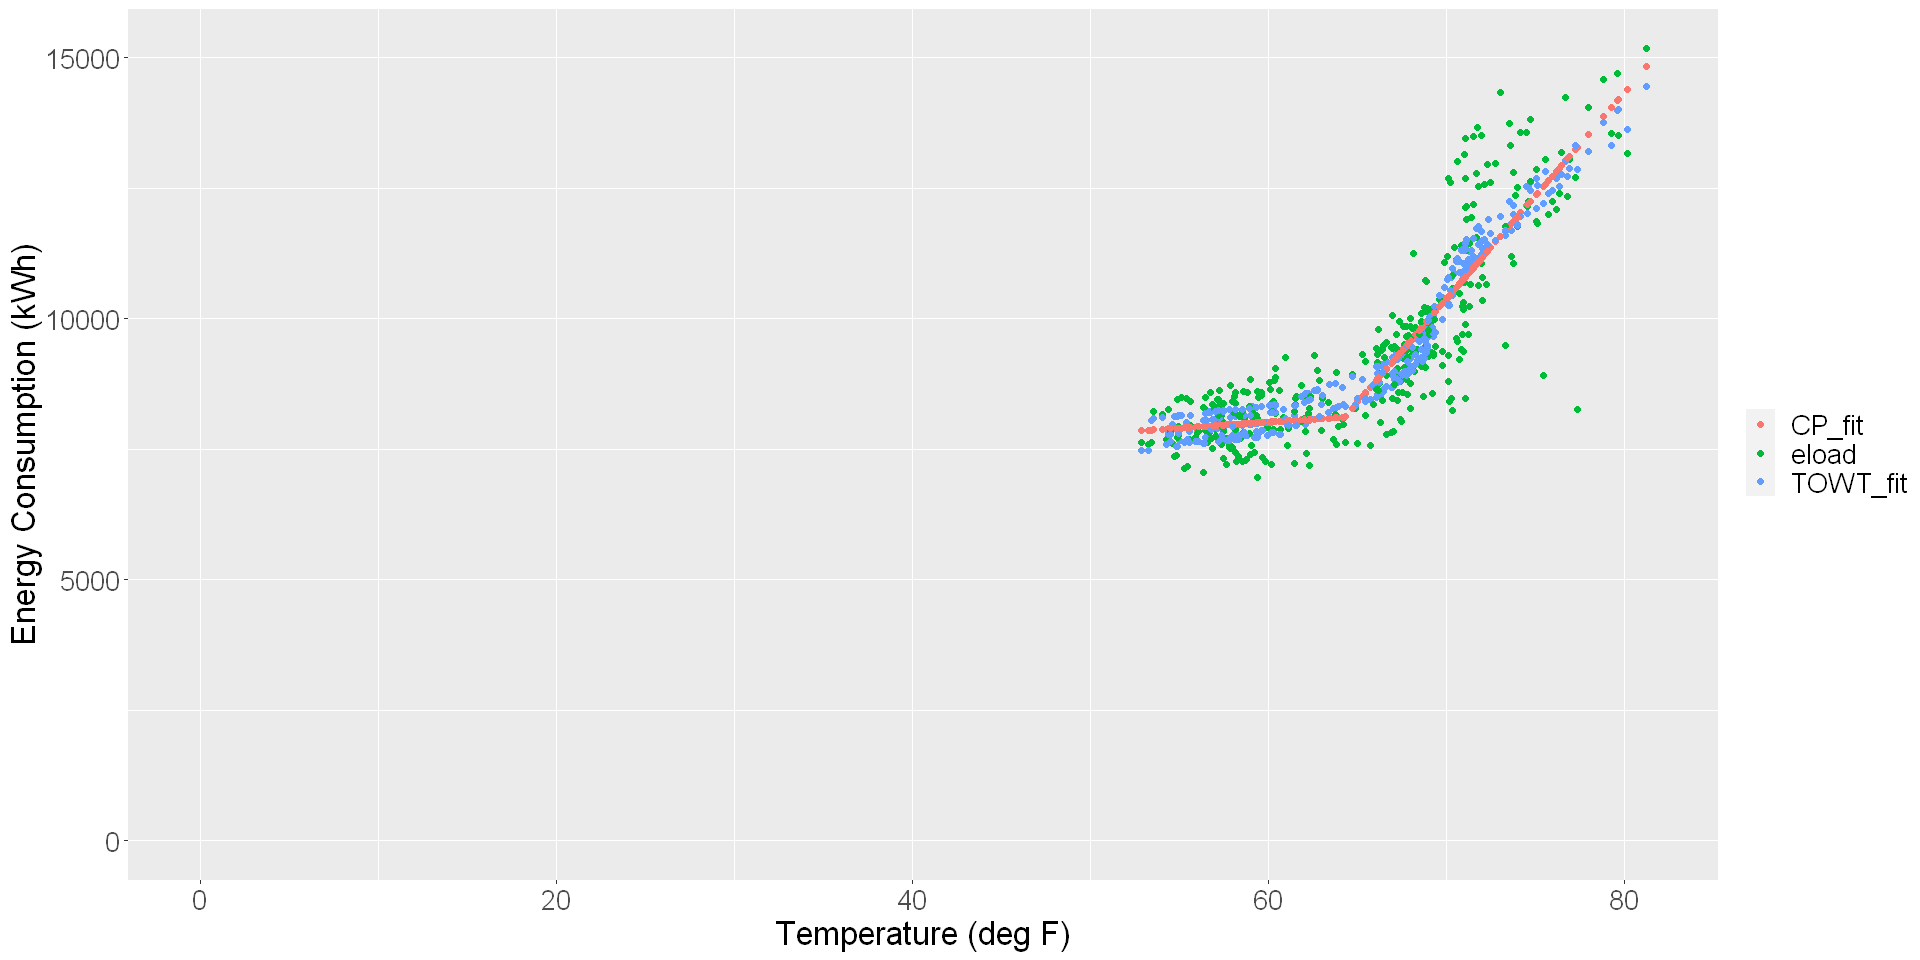

In [28]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(baseline_scatter_df)

In [53]:
## Model Summary Stats 

generate_summary_stats <- function(model1, model2) {
    
    model1_stats <- nmecr::calculate_summary_statistics(model1)
    model1_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = model1,
                                        model_summary_statistics = model1_stats,
                                        confidence_level = 90)

    model1_metrics <- dplyr::bind_cols(model1_stats, model1_unc)

    model2_stats <- nmecr::calculate_summary_statistics(model2)

    model2_unc <- nmecr::calculate_savings_and_uncertainty(modeled_object = model2,
                                        model_summary_statistics = model2_stats,
                                        confidence_level = 90)

    model2_metrics <- dplyr::bind_cols(model2_stats, model2_unc)

    metrics <- dplyr::bind_rows(model1_metrics, model2_metrics)
    metrics <- metrics[, c(1:5,9:10)]
    names(metrics) <- c("R2", "Adj. R2", "CVRMSE%", "NDBE%", "NMBE%", 
                    "Savings Uncertainty @ 10% Savings", "Savings Fraction for 50% Uncertainty")

    metrics$`NDBE%` <- as.numeric(metrics$`NDBE%`)
    metrics$`NMBE%` <- as.numeric(metrics$`NMBE%`)

    metrics <- metrics %>%
        mutate("Algorithm" = c("3PC", "TOWT"))

    metrics <- metrics %>%
        select(c("Algorithm", everything()))

    return(metrics)    
}



In [54]:
generate_summary_stats(three_parameter_cooling_model, TOWT_model)

Algorithm,R2,Adj. R2,CVRMSE%,NDBE%,NMBE%,Savings Uncertainty @ 10% Savings,Savings Fraction for 50% Uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3PC,0.78,0.78,9.11,6.421013e-16,6.474522e-16,0.2769340,0.05538681
TOWT,0.80,0.79,8.67,-2.750334e-14,-2.852489e-14,0.2831296,0.05662593


The NMEC Rulebook references the Site-Level NMEC Technical Guidance by LBNL to evaluate a model's goodness-of-fit, which provides the following three thresholds:

- CV(RMSE) < 25%
- NMBE between -0.5% and +0.5%
- R2 > 0.7

Both algorithms perform quite well, when assessed using these three metric thresholds. The TOWT algorithm performs slightly better in terms of R2 and random error; both algorithms have near-zero bias error.

The guidance, however, also notes that "...these do not comprise pass/fail criteria, but rather an analysis that will feed into an interpretation of model suitability". 

The downside of having thresholds or criteria is that very quickly, these are taken out-of-context and evaluated in a vaccum. Many such thresholds go on to be a part of the popular culture like the 10,000 hour rule to achieve mastery of a subject or the 10,000 steps a day rule to sustain a healthy body. The 10,000 hour rule has been debunked many times [Link:1](https://medium.com/swlh/the-10-000-hour-rule-is-dead-6fe781735569), [Link:2](https://www.theguardian.com/science/2019/aug/21/practice-does-not-always-make-perfect-violinists-10000-hour-rule) and while I'm not here to debunk any NMEC guidance, I would like to show you one way to interpret the thresholds.

The guidance says that model goodness-of-fit analysis feeds into an interpretation of model suitability. When we conduct a predictability analysis, we review 12 months of data for trends and NREs. Limiting our focus to 12 months leaves us oblivious to slow moving overall trends or NREs outside the 12-month period. 

One such NRE is the onset of the COVID-19 pandemic. The shelter-in-place restrictions first went into effect on March 19th, 2020. The dataset we have here is completely within the shutdown period, and its hard for me to imagine a facility that is continuing to operate and use the same amount of energy that it did prior to March, 2020. A good way to check this is to compare the model's predictions to actual energy use prior to March 2020.

### Predictive Accuracy

In [33]:
energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2020-03-31",
                                          end_date = "2021-04-01", 
                                          convert_to_data_interval = "Daily")

prediction_energy_temp_df <- nmecr::create_dataframe(eload_data, temp_data, start_date = "2019-03-31",
                                          end_date = "2020-03-30", 
                                          convert_to_data_interval = "Daily")

In [34]:
CP_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = three_parameter_cooling_model)

TOWT_prediction <- nmecr::calculate_model_predictions(training_data = energy_temp_df,
                                                           prediction_data = prediction_energy_temp_df,
                                                           modeled_object = TOWT_model)

all_predictions_df <- CP_prediction %>%
    select(-c("predictions")) %>%
    mutate('CP_predictions' = CP_prediction$predictions) %>%
    mutate('TOWT_predictions' = TOWT_prediction$predictions)

prediction_scatter_df <- tidyr::pivot_longer(all_predictions_df,
                                           cols = c("eload", "CP_predictions", "TOWT_predictions"))

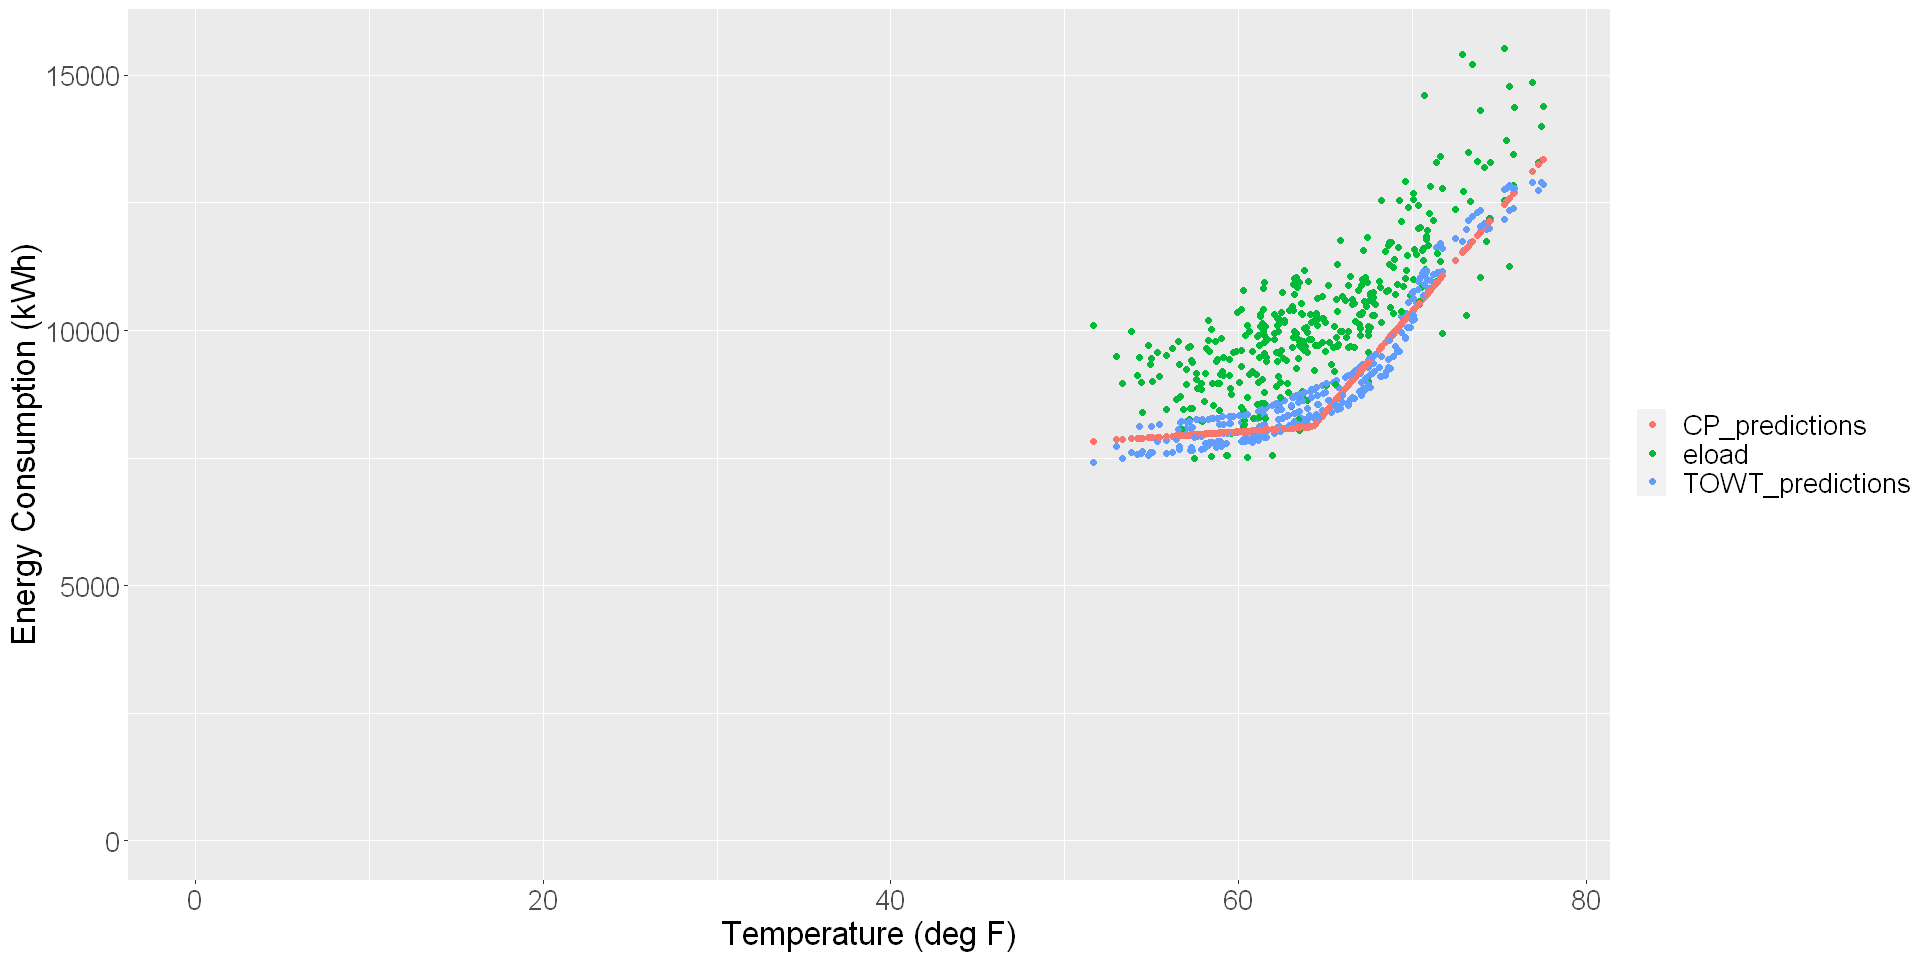

In [36]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(prediction_scatter_df)

In [40]:
calculate_prediction_errors <- function(data) {
    
    CP_prediction_error <- sum(data$eload - data$CP_predictions, na.rm = T)/
                            sum(data$eload, na.rm = T)
    TOWT_prediction_error <- sum(data$eload - data$TOWT_predictions, na.rm = T)/
                            sum(data$eload, na.rm = T)
    
    CP_prediction_error <- paste0(round(100*CP_prediction_error, 2), "%")

    TOWT_prediction_error <- paste0(round(100*TOWT_prediction_error, 2), "%")
    
    return(list(CP_prediction_error, TOWT_prediction_error))   
    
}


In [47]:
prediction_errors <- calculate_prediction_errors(all_predictions_df)

message("Prediction Error using the Three Parameter cooling model is ", prediction_errors[1], 
        " while the error for the TOWT model is ", prediction_errors[2])

Prediction Error using the Three Parameter cooling model is 12.92% while the error for the TOWT model is 12.23%



Both models perform equally bad when it comes to predictive accuracy.


So, can we provide the models with some information that would help them account for the changes due to the shutdown?

## Add in the occupancy variable

In [48]:
occupancy_data <- readRDS("Data/Processed Occupancy Data - multiyear.rds")

In [49]:
energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                              additional_independent_variables = occupancy_data,
                                              additional_variable_aggregation = c(median),
                                              start_date = "2020-03-31",
                                              end_date = "2021-04-01", 
                                              convert_to_data_interval = "Daily")

prediction_energy_temp_df_upd <- nmecr::create_dataframe(eload_data, temp_data, 
                                                         additional_independent_variables = occupancy_data,
                                                         additional_variable_aggregation = c(median),
                                                         start_date = "2019-03-31",
                                                         end_date = "2020-03-30", 
                                                         convert_to_data_interval = "Daily")

In [21]:
three_parameter_cooling_model_upd <- nmecr::model_with_CP(training_data = energy_temp_df_upd,
                                               model_input_options = nmecr::assign_model_inputs(regression_type = "3PC"))

TOWT_model_upd <- nmecr::model_with_TOWT(training_data = energy_temp_df_upd, 
                                     model_input_options = nmecr::assign_model_inputs(regression_type = "TOWT"))

actual_modeled_df_upd <- three_parameter_cooling_model_upd$training_data %>%
    select(-c("model_fit")) %>%
    mutate('CP_fit' = three_parameter_cooling_model_upd$training_data$model_fit) %>%
    mutate('TOWT_fit' = TOWT_model_upd$training_data$model_fit)

baseline_scatter_df_upd <- tidyr::pivot_longer(actual_modeled_df_upd,
                                           cols = c("eload", "CP_fit", "TOWT_fit"))

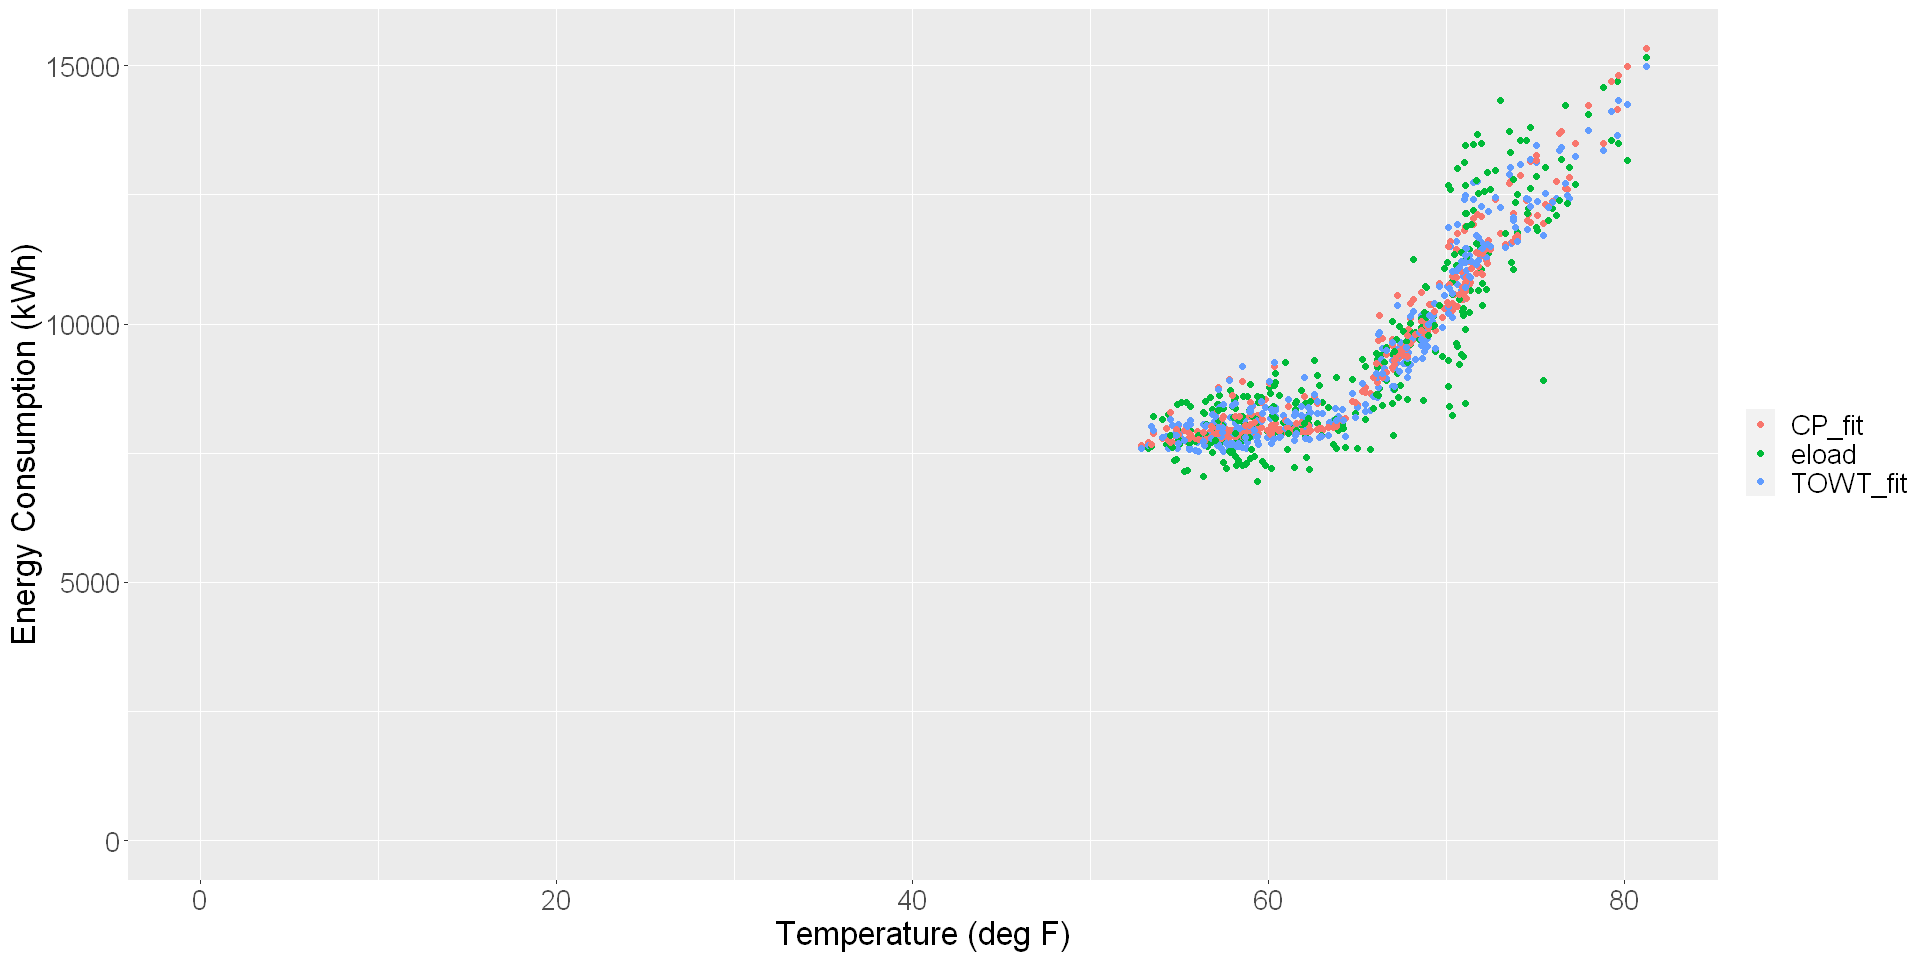

In [50]:
options(repr.plot.width=16, repr.plot.height=8)
generate_scatter_plot(baseline_scatter_df_upd)

In [51]:
prediction_errors <- calculate_prediction_errors(actual_modeled_df_upd)

message("Prediction Error using the Three Parameter cooling model is ", prediction_errors[1], 
        " while the error for the TOWT model is ", prediction_errors[2])

Prediction Error using the Three Parameter cooling model is 0% while the error for the TOWT model is 0%



In [55]:
generate_summary_stats(three_parameter_cooling_model_upd, TOWT_model_upd)

Algorithm,R2,Adj. R2,CVRMSE%,NDBE%,NMBE%,Savings Uncertainty @ 10% Savings,Savings Fraction for 50% Uncertainty
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3PC,0.86,0.86,7.64,-6.037838e-17,-6.114266e-17,0.1983237,0.03966474
TOWT,0.88,0.87,7.23,-3.915538e-14,-4.094680e-14,0.1976433,0.03952866
